# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [1]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od


**1 . Realizamos la carga de los datos directamente desde Kaggle**.

In [2]:

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/flowers'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jennyortizre
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:02<00:00, 80.6MB/s]


**2. Identificamos el directorio y mostramos el contenido de la carpeta flowers**.


In [3]:
import os
root_dir = './flowers-recognition'
data_dir = './flowers-recognition/flowers'
print(os.listdir(data_dir))

['dandelion', 'tulip', 'daisy', 'rose', 'sunflower']


**3. Para facilitar la clasificación de las imágenes, renombramos cada una, incluyendo dentro del nombre la clase a la cual pertenece:**

In [4]:
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes):
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

**4. Personalización del dataset**

* Se importan las clases Dataset e Image para crear un dataset personalizado.
* Se definen las funciones parse_species (para extraer la especie del nombre del archivo) y open_image (para abrir una imagen).
* Se define la clase FlowersDataset que hereda de Dataset para cargar y preprocesar las imágenes.



In [5]:

from torch.utils.data import Dataset
from PIL import Image

def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:
            for file in os.listdir(root_dir + '/' + classes):
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx

**5. Aumentamos la data aplicando:**
* Se importan las transformaciones de imágenes de torchvision.transforms.
* Se define el tamaño de la imagen y las estadísticas de normalización.
* Se crea una serie de transformaciones para preprocesar las imágenes (redimensionar, recortar, voltear, etc.).
Se crea una instancia de FlowersDataset utilizando las transformaciones definidas.

In [59]:
import torchvision.transforms as T

img_size = 128
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.224))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(128, padding=4, padding_mode='constant'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.01, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
dataset = FlowersDataset(data_dir, transform=transform)

**6. Visualización de la imagen**

* En este paso creamos una función que nos permite desnormalizar la imagen que básicamente es revertir el efecto aplicado a la misma en el paso anterior.
* En la función Show_image, buscamos mostrar la imagen con su respectiva etiqueta de clase

In [60]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(3,1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [61]:
print(*dataset[1746][0].shape)

3 128 128


In [62]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).view(3, 1, 1)  # Cambia la forma a (3, 1, 1)
    stds = torch.tensor(stds).view(3, 1, 1)    # Cambia la forma a (3, 1, 1)
    return images * stds + means


Label: tulip (1)


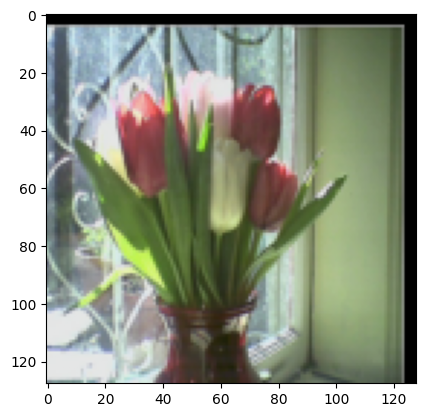

In [63]:
show_image(*dataset[1749]);

**7. Definición del conjunto de datos de validación**

In [64]:
from torch.utils.data import random_split

random_seed = 55
torch.manual_seed(random_seed)

val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [65]:
len(dataset)

4317

**8. Del total de dataset, dividimos una parte para entrenamiento y letra parte para test**

In [66]:
train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

**9. Este código nos permite optimizar la forma en la que se cargan los datos**

In [67]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [68]:
from torchvision.utils import make_grid

def show_batch(batch_size, dl):
    for images, labels in dl:
        batch_size = 128
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [69]:
len(valid_dl)

431

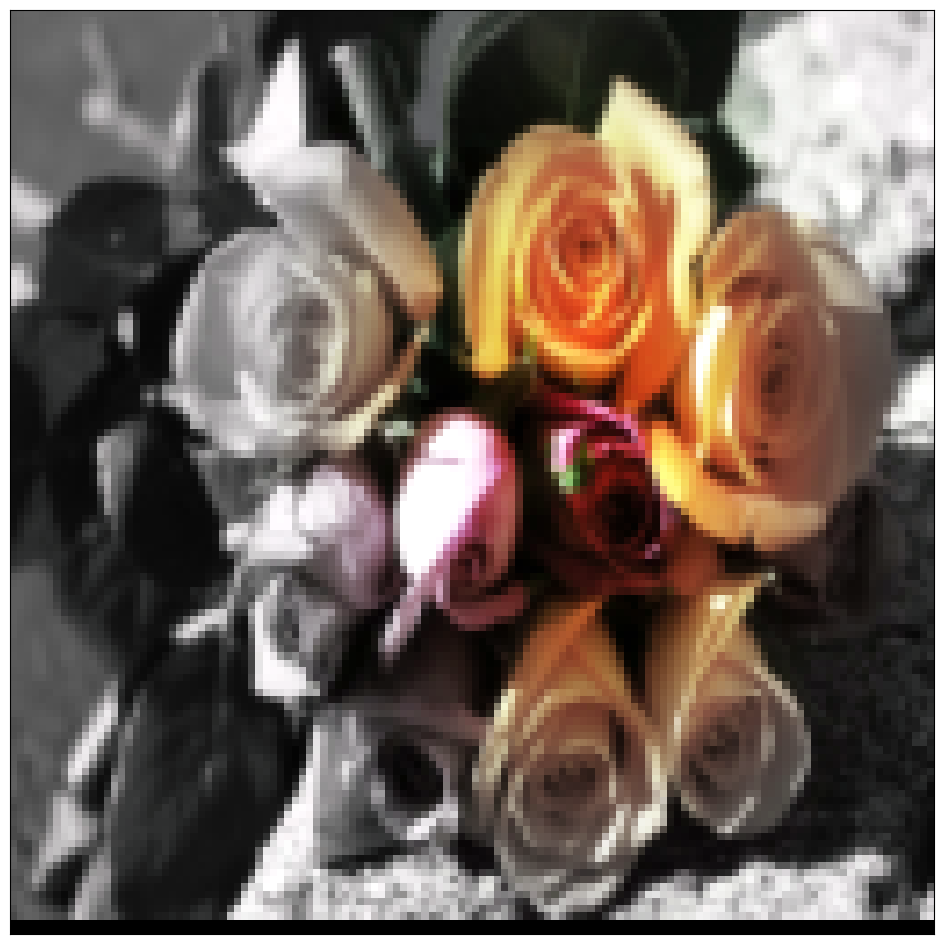

In [70]:
show_batch(12, train_dl)

**10. Definición de funciones de entrenamiento y test**

A continuación definimos dos funciones que nos permiran ejecutar el entrenamiento y el test, en estas funcines recibimos paráetros como los datos, el modelo, la función de pérdida y los optimizadores.

In [71]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [72]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

**11. Importamos las librerías necesarias para ejecutar el modelo**



In [73]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



**12. Uso de red preentrenada**

Luego de realizar varias pruebas encontramos que la  red preentrenada que nos arrojó la mejor precisión es la VGG16, en el codigo siguiente veremos la definición de la red preentrenada y el instaciamiento de la misma.

In [74]:
model = models.vgg16(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.6MB/s]


In [75]:
# Instantiate and print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=1e-3)

**13. Prueba del Modelo**

Finalmente ejecutamos el entrenamiento de la red con 10 épocas, una fución de pérdida Cross Entropy y una optimización Adam.

**14. Conclusiones:**

En el modelo, logramos una precisión de 83.5% lo cual es bastante buena con relación a las iteraciones anteriores realizadas con redes como resnet18 o resnet50, las cuáles la precisión máxima llegaba a 40%

In [78]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(valid_dl, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 21.408245  [    0/ 3886]
loss: 0.738904  [  500/ 3886]
loss: 0.188223  [ 1000/ 3886]
loss: 4.817657  [ 1500/ 3886]
loss: 4.468538  [ 2000/ 3886]
loss: 0.004852  [ 2500/ 3886]
loss: 0.000000  [ 3000/ 3886]
loss: 0.258891  [ 3500/ 3886]
Test Error: 
 Accuracy: 72.2%, Avg loss: 1.140445 

Epoch 2
-------------------------------
loss: 4.185413  [    0/ 3886]
loss: 0.000000  [  500/ 3886]
loss: 0.581986  [ 1000/ 3886]
loss: 0.000023  [ 1500/ 3886]
loss: 3.802313  [ 2000/ 3886]
loss: 1.398583  [ 2500/ 3886]
loss: 0.000003  [ 3000/ 3886]
loss: 0.000000  [ 3500/ 3886]
Test Error: 
 Accuracy: 75.6%, Avg loss: 1.176366 

Epoch 3
-------------------------------
loss: 0.000000  [    0/ 3886]
loss: 0.000004  [  500/ 3886]
loss: 0.000000  [ 1000/ 3886]
loss: 4.007401  [ 1500/ 3886]
loss: 7.802743  [ 2000/ 3886]
loss: 0.028322  [ 2500/ 3886]
loss: 8.397317  [ 3000/ 3886]
loss: 0.000000  [ 3500/ 3886]
Test Error: 
 Accuracy: 79.8%, Avg loss: 1.096547 

Epo